In [ ]:
!pip install conllu

In [ ]:
!pip install torchtext

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from conllu import parse_incr
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim.downloader
from torch.utils.data import Dataset
from torchtext.vocab import build_vocab_from_iterator, Vocab
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
torch.manual_seed(42)

In [ ]:
tag_map = {'VERB': 0,
 'ADJ': 1,
 'DET': 2,
 'ADP': 3,
 'PRON': 4,
 'CCONJ': 5,
 'NUM': 6,
 'INTJ': 7,
 'ADV': 8,
 'AUX': 9,
 'PROPN': 10,
 'NOUN': 11,
 'PART': 12}

In [ ]:
def get_data(path):
  data = []
  data_file = open(path, "r", encoding="utf-8")
  for sentence in parse_incr(data_file):
      sent = sentence.metadata
      tok_sent = sent_tokenize(sent['text'])
      words = []
      tags = []
      for token in sentence:
          # print(f"Word: {token['form']}, POS Tag: {token['upostag']}")
          if token['upostag'] != 'SYM':
            words.append(token['form'])
            tags.append(tag_map[token['upostag']])
      data.append((words, tags))
  return data

In [ ]:
train_data = get_data("/content/drive/MyDrive/INLP/Assignment - 2/en_atis-ud-train.conllu")
val_data = get_data("/content/drive/MyDrive/INLP/Assignment - 2/en_atis-ud-dev.conllu")
test_data = get_data("/content/drive/MyDrive/INLP/Assignment - 2/en_atis-ud-test.conllu")

In [ ]:
def get_sent_tags(data):
  sentences = []
  tags = []
  for d in data:
    sentences.append(d[0])
    tags.append(d[1])
  return sentences, tags

In [ ]:
train_sent, train_tags = get_sent_tags(train_data)
val_sent, val_tags = get_sent_tags(val_data)
test_sent, test_tags = get_sent_tags(test_data)

In [ ]:
START_TOKEN = "<s>"
END_TOKEN = "</s>"
UNKNOWN_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"

In [ ]:
class POSTagDataset(Dataset):
    def __init__(self, data: list[tuple[list[str], int]], num_classes, vocabulary:Vocab|None=None):
        self.sentences = [i[0] for i in data] # list of sentences
        self.labels = [i[1] for i in data]

        # Replace words which occur less than 5 times with <UNK>
        all_words = [word for sentence in self.sentences for word in sentence]

        word_counts = Counter(all_words)
        frequency_threshold = 5

        infrequent_words = {word for word, count in word_counts.items() if count < frequency_threshold}
        sentences_with_unk = [["<unk>" if word in infrequent_words else word for word in sentence]for sentence in self.sentences]

        self.sentences = sentences_with_unk
        # print("length of sentences: ", len(self.sentences))
        # print("length of labels: ", len(self.labels))
        # print("length of embeddings: ", len(self.embeddings))

        if vocabulary is None:
            self.vocabulary = build_vocab_from_iterator(self.sentences, specials=[START_TOKEN, END_TOKEN, UNKNOWN_TOKEN, PAD_TOKEN]) # use min_freq for handling unkown words better
            self.vocabulary.set_default_index(self.vocabulary[UNKNOWN_TOKEN])
        else:
            self.vocabulary = vocabulary

        print("pad token:", self.vocabulary[PAD_TOKEN])

    def __len__(self) -> int:
        return len(self.sentences)

    def __getlabels__(self) -> list[int]:
        return self.labels

    def __getembeddings__(self) -> list[list[float]]:
        return self.embeddings

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Get the datapoint at `index`."""
        # return torch.tensor(self.vocabulary.lookup_indices(self.sentences[index])), torch.tensor(self.labels[index])
        return torch.tensor(self.vocabulary.lookup_indices(self.sentences[index])), torch.tensor(self.labels[index])

    def collate(self, batch: list[tuple[torch.Tensor, torch.Tensor]]) -> tuple[torch.Tensor, torch.Tensor]:
      """Given a list of datapoints, batch them together"""
      sentences = [i[0] for i in batch]
      labels = [i[1] for i in batch]
      padded_sentences = pad_sequence(sentences, batch_first=True, padding_value=self.vocabulary[PAD_TOKEN]) # pad sentences with pad token id
      padded_labels = pad_sequence(labels, batch_first=True, padding_value=torch.tensor(77)) # pad labels with 0 because pad token cannot be entities

      return padded_sentences, padded_labels


In [ ]:
train_dataset = POSTagDataset(train_data,len(tag_map))
val_dataset = POSTagDataset(val_data,len(tag_map), vocabulary=train_dataset.vocabulary)
test_dataset = POSTagDataset(test_data,len(tag_map), vocabulary=train_dataset.vocabulary)

pad token: 3
pad token: 3
pad token: 3


In [ ]:
print("length of train vocabulary: ", len(train_dataset.vocabulary))
print("length of val vocabulary: ", len(val_dataset.vocabulary))
print("length of test vocabulary: ", len(test_dataset.vocabulary))

length of train vocabulary:  414
length of val vocabulary:  414
length of test vocabulary:  414


In [ ]:
import pickle

def save_vocab(vocab, filename):
    with open(filename, 'wb') as file:
        pickle.dump(vocab, file)

In [ ]:
vocab = train_dataset.vocabulary.get_stoi()
vocab

{'trips': 412,
 'thrift': 411,
 'these': 410,
 'taxi': 409,
 'minnesota': 405,
 'lufthansa': 404,
 'logan': 403,
 'let': 402,
 'indiana': 401,
 'hp': 400,
 'fourteenth': 399,
 'february': 398,
 'codes': 395,
 'anywhere': 393,
 '466': 390,
 "'ll": 389,
 'tower': 387,
 'ohio': 382,
 'lunch': 379,
 'january': 377,
 'dfw': 374,
 'both': 373,
 'y': 368,
 'when': 367,
 'transport': 366,
 'q': 362,
 'nineteenth': 360,
 'midnight': 359,
 'm80': 358,
 'hours': 357,
 'eleventh': 356,
 'departure': 355,
 'area': 354,
 'rent': 364,
 "'re": 352,
 'yes': 351,
 'where': 350,
 'traveling': 349,
 'thirty': 348,
 'shortest': 345,
 'north': 342,
 'layover': 339,
 'hi': 338,
 'explain': 337,
 'but': 334,
 '1': 332,
 'tickets': 330,
 'arrangements': 333,
 'jfk': 327,
 'far': 324,
 'f': 323,
 'again': 322,
 'should': 320,
 'listing': 317,
 'either': 316,
 'over': 383,
 'classes': 314,
 'ap': 313,
 'live': 378,
 'twelfth': 312,
 'restriction': 310,
 'midwest': 309,
 'express': 308,
 'rental': 304,
 'dl': 302

In [ ]:
import os
os.chdir("/content/drive/MyDrive/INLP/Assignment - 2")
os.getcwd()

'/content/drive/MyDrive/INLP/Assignment - 2'

In [ ]:
# save_vocab(vocab, "lstm_model1_vocab.pkl")

In [ ]:
vocab[PAD_TOKEN]

3

In [ ]:
vocab_size = len(train_dataset.vocabulary)

In [ ]:
vocab_size, len(train_dataset.vocabulary.get_stoi())

(414, 414)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn = train_dataset.collate)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn = val_dataset.collate)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn = test_dataset.collate)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class BiLSTMPOSTagger(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_dim, output_dim):
        super(BiLSTMPOSTagger, self).__init__()
        self.embed = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 *  hidden_dim, output_dim)

    def forward(self, input: torch.Tensor):
        embeddings = self.embed(input)
        output, _ = self.lstm(embeddings)
        output = self.fc(output)

        return output

In [ ]:
INPUT_DIM = vocab_size
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
output_dim = len(tag_map)
print(output_dim)
model = BiLSTMPOSTagger(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, output_dim)

13


In [ ]:
loss_function = nn.CrossEntropyLoss(ignore_index=77)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from tqdm import tqdm

In [ ]:
def get_labels_preds(predictions, labels, pad_index = 77):
    # Exclude padded tokens from both predictions and labels
    non_pad_mask = labels != pad_index
    predictions = predictions[non_pad_mask]
    labels = labels[non_pad_mask]

    return predictions, labels
    # Calculate accuracy
    correct_predictions = (predictions == labels).sum().item()
    total_predictions = len(labels)

    accuracy = correct_predictions / total_predictions
    return accuracy

a = [1,2,3,77,77,77]
b = [3,2,3,6,6,6]
p, l = get_labels_preds(b,a)
print("l: ", l)
print("p: ", p)

l:  2
p:  2


In [ ]:
idx = a.index(77)
a[:idx], b[:idx]

([1, 2, 3], [3, 2, 3])

In [ ]:
accuracy_score(a[:idx], b[:idx])

0.6666666666666666

In [ ]:
def calculate_accuracy(predictions_list, labels_list, pad_index=77):
    total_correct = 0
    total_non_pad = 0

    for predictions, labels in zip(predictions_list, labels_list):
        # Convert each inner list to a PyTorch tensor
        predictions = torch.tensor(predictions)
        labels = torch.tensor(labels)

        # Exclude padded tokens from both predictions and labels
        non_pad_mask = labels != pad_index
        predictions = predictions[non_pad_mask]
        labels = labels[non_pad_mask]

        # Update total counts
        total_correct += (predictions == labels).sum().item()
        total_non_pad += len(labels)

    # Calculate accuracy
    accuracy = total_correct / total_non_pad if total_non_pad > 0 else 0
    return accuracy

In [ ]:
# def calculate_classification_metrics(predictions_list, labels_list, pad_index=77):
#     all_predictions = []
#     all_labels = []

#     for predictions, labels in zip(predictions_list, labels_list):
#         # Convert each inner list to a NumPy array
#         predictions = np.array(predictions)
#         labels = np.array(labels)

#         # Exclude padded tokens from both predictions and labels
#         non_pad_mask = labels != pad_index
#         predictions = predictions[non_pad_mask]
#         labels = labels[non_pad_mask]

#         # Collect all predictions and labels
#         all_predictions.extend(predictions)
#         all_labels.extend(labels)

#     # Convert to NumPy arrays
#     all_predictions = np.array(all_predictions)
#     all_labels = np.array(all_labels)
#     print(type(all_predictions))
#     print(type(all_labels))
#     # return all_predictions, all_labels
#     # Calculate precision, recall, and F1 score
#     precision_micro = precision_score(all_labels, all_predictions, average='micro', zero_division = 1)
#     recall_micro = recall_score(all_labels, all_predictions, average='micro', zero_division = 1)
#     f1_micro = f1_score(all_labels, all_predictions, average='micro', zero_division = 1)

#     precision_macro = precision_score(all_labels, all_predictions, average='macro', zero_division = 1)
#     recall_macro = recall_score(all_labels, all_predictions, average='macro', zero_division = 1)
#     f1_macro = f1_score(all_labels, all_predictions, average='macro', zero_division = 1)

#     # Calculate confusion matrix
#     confusion_mat = confusion_matrix(all_labels, all_predictions)

#     return {
#         'precision_micro': precision_micro,
#         'recall_micro': recall_micro,
#         'f1_micro': f1_micro,
#         'precision_macro': precision_macro,
#         'recall_macro': recall_macro,
#         'f1_macro': f1_macro,
#         'confusion_matrix': confusion_mat
#     }



In [ ]:
num_epochs = 20
losses = []
accs = []
total_step = len(train_loader)

true_val_labels = []
predicted_val_labels = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
  total_correct = 0
  total_samples = 0
  val_accs = []
  val_losses = []
  train_accs = []
  train_losses = []
  for i, (sent, label) in enumerate(train_loader):
    # print("sent:" , sent)
    # print("label shape: ", label.shape)
    sent = sent.to(device)
    label = label.to(device)

    outputs = model(sent)
    to_loss_outputs = outputs.permute(0, 2, 1)
    # outputs = outputs.view(-1, outputs.size(2))  # Reshape to (batch_size * sequence_length, num_classes)

    # print("output shape: ", outputs.shape)
    # print("label shape: ", label.shape)
    # print("output: ", outputs)
    # print("label: ", label)
    # break
    loss = loss_function(to_loss_outputs, label)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # print("outputs data: ", outputs.data.shape)
    _, predicted = torch.max(outputs.data, 2)
    total_samples += label.size(0)
    # print("predicted shape: ", predicted.shape)
    # print("label shape: ", label.shape)
    # print("pred: ", predicted[0])
    # print("label: ", label[0])
    # break
    # total_correct += (predicted == label).sum().item()
    # train_losses.append(loss.item())
    # train_accs.append((total_correct / total_samples) * 100)
    # correct_predictions = (predicted == label)

    # # Calculate accuracy for each position in the sequence
    # accuracy_per_position = correct_predictions.float().mean(dim=0)

    # # Calculate overall accuracy by taking the mean across the sequence
    # overall_accuracy = accuracy_per_position.mean().item()
    overall_accuracy = calculate_accuracy(predicted, label)

    train_accs.append(overall_accuracy)
    train_losses.append(loss.item())

    # if (i+1) % 100 == 0:
    #   print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} Accuracy: {:.4f}\n'
    #   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), overall_accuracy*100))

  for i, (sent, label) in enumerate(val_loader):


    sent = sent.to(device)
    label = label.to(device)

    outputs = model(sent)
    to_loss_outputs = outputs.permute(0, 2, 1)
    loss = loss_function(to_loss_outputs, label)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs.data, 2)
    total_samples += label.size(0)
    overall_accuracy = calculate_accuracy(predicted, label)
    # print("Val acc: ", overall_accuracy)

    true_val_labels.extend(label.cpu().numpy())
    predicted_val_labels.extend(predicted.cpu().numpy())

    val_accs.append(overall_accuracy)
    val_losses.append(loss.item())


  avg_train_loss = np.array(train_losses).mean()
  avg_train_accs = np.array(train_accs).mean()
  avg_val_loss = np.array(val_losses).mean()
  avg_val_accs = np.array(val_accs).mean()
  losses.append(avg_val_loss)
  accs.append(avg_val_accs)
  print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Val Loss: {:.4f}, Val Accuracy: {:.2f}%'
  .format(epoch+1, num_epochs, avg_train_loss, avg_train_accs*100, avg_val_loss, avg_val_accs*100))

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-30-d96154c9d0d4>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(predictions)
<ipython-input-30-d96154c9d0d4>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
Epochs:   5%|▌         | 1/20 [01:00<19:13, 60.72s/it]

Epoch [1/20], Train Loss: 0.2938, Train Accuracy: 91.18%, Val Loss: 0.1423, Val Accuracy: 95.70%


Epochs:  10%|█         | 2/20 [01:45<15:28, 51.57s/it]

Epoch [2/20], Train Loss: 0.0581, Train Accuracy: 98.23%, Val Loss: 0.1014, Val Accuracy: 96.56%


Epochs:  15%|█▌        | 3/20 [02:32<14:00, 49.46s/it]

Epoch [3/20], Train Loss: 0.0471, Train Accuracy: 98.45%, Val Loss: 0.0803, Val Accuracy: 97.23%


Epochs:  20%|██        | 4/20 [03:19<12:51, 48.25s/it]

Epoch [4/20], Train Loss: 0.0374, Train Accuracy: 98.76%, Val Loss: 0.0560, Val Accuracy: 98.00%


Epochs:  25%|██▌       | 5/20 [04:21<13:20, 53.39s/it]

Epoch [5/20], Train Loss: 0.0311, Train Accuracy: 98.97%, Val Loss: 0.0423, Val Accuracy: 98.61%


Epochs:  30%|███       | 6/20 [05:09<11:59, 51.39s/it]

Epoch [6/20], Train Loss: 0.0254, Train Accuracy: 99.13%, Val Loss: 0.0309, Val Accuracy: 99.07%


Epochs:  35%|███▌      | 7/20 [05:55<10:47, 49.80s/it]

Epoch [7/20], Train Loss: 0.0214, Train Accuracy: 99.28%, Val Loss: 0.0286, Val Accuracy: 99.01%


Epochs:  40%|████      | 8/20 [06:40<09:36, 48.04s/it]

Epoch [8/20], Train Loss: 0.0185, Train Accuracy: 99.38%, Val Loss: 0.0174, Val Accuracy: 99.48%


Epochs:  45%|████▌     | 9/20 [07:24<08:35, 46.85s/it]

Epoch [9/20], Train Loss: 0.0160, Train Accuracy: 99.44%, Val Loss: 0.0158, Val Accuracy: 99.60%


Epochs:  50%|█████     | 10/20 [08:08<07:39, 45.99s/it]

Epoch [10/20], Train Loss: 0.0117, Train Accuracy: 99.57%, Val Loss: 0.0139, Val Accuracy: 99.55%


Epochs:  55%|█████▌    | 11/20 [08:51<06:46, 45.20s/it]

Epoch [11/20], Train Loss: 0.0114, Train Accuracy: 99.63%, Val Loss: 0.0136, Val Accuracy: 99.67%


Epochs:  60%|██████    | 12/20 [09:35<05:58, 44.77s/it]

Epoch [12/20], Train Loss: 0.0086, Train Accuracy: 99.70%, Val Loss: 0.0125, Val Accuracy: 99.62%


Epochs:  65%|██████▌   | 13/20 [10:18<05:09, 44.22s/it]

Epoch [13/20], Train Loss: 0.0075, Train Accuracy: 99.76%, Val Loss: 0.0080, Val Accuracy: 99.71%


Epochs:  70%|███████   | 14/20 [11:02<04:24, 44.04s/it]

Epoch [14/20], Train Loss: 0.0062, Train Accuracy: 99.82%, Val Loss: 0.0053, Val Accuracy: 99.86%


Epochs:  75%|███████▌  | 15/20 [11:44<03:37, 43.50s/it]

Epoch [15/20], Train Loss: 0.0054, Train Accuracy: 99.83%, Val Loss: 0.0054, Val Accuracy: 99.81%


Epochs:  80%|████████  | 16/20 [12:26<02:52, 43.17s/it]

Epoch [16/20], Train Loss: 0.0069, Train Accuracy: 99.80%, Val Loss: 0.0076, Val Accuracy: 99.73%


Epochs:  85%|████████▌ | 17/20 [13:10<02:09, 43.22s/it]

Epoch [17/20], Train Loss: 0.0040, Train Accuracy: 99.88%, Val Loss: 0.0054, Val Accuracy: 99.81%


Epochs:  90%|█████████ | 18/20 [13:54<01:26, 43.49s/it]

Epoch [18/20], Train Loss: 0.0039, Train Accuracy: 99.88%, Val Loss: 0.0052, Val Accuracy: 99.84%


Epochs:  95%|█████████▌| 19/20 [14:39<00:44, 44.13s/it]

Epoch [19/20], Train Loss: 0.0042, Train Accuracy: 99.89%, Val Loss: 0.0038, Val Accuracy: 99.87%


Epochs: 100%|██████████| 20/20 [15:22<00:00, 46.14s/it]

Epoch [20/20], Train Loss: 0.0026, Train Accuracy: 99.92%, Val Loss: 0.0063, Val Accuracy: 99.80%


In [ ]:
new_loss = []
for l in losses:
  new_loss.append(l.item())

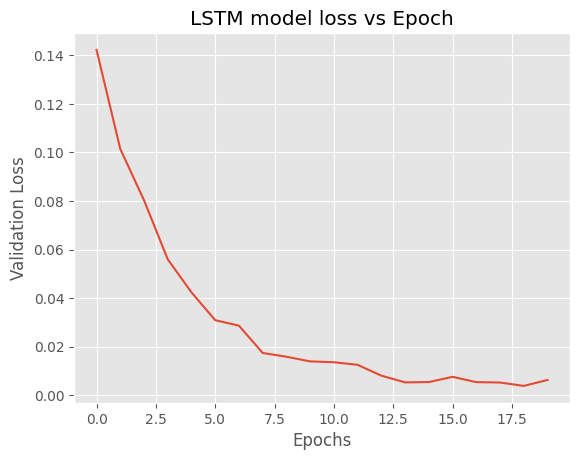

In [ ]:
plt.plot(range(len(new_loss)), new_loss)
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("LSTM model loss vs Epoch")
plt.show()

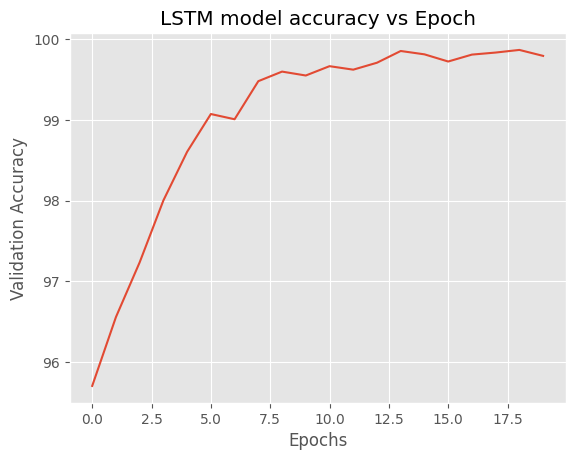

In [ ]:
accs = [value * 100 for value in accs]
plt.plot(range(len(accs)), accs)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("LSTM model accuracy vs Epoch")
plt.show()

In [ ]:
# def extract_actual_preds_and_labels(predictions_list, labels_list, pad_index=77):
#     all_actual_preds = []
#     all_actual_labels = []

#     for predictions, labels in zip(predictions_list, labels_list):
#         # Find non-pad indices
#         non_pad_indices = [i for i, label in enumerate(labels) if label != pad_index]

#         # Extract actual predictions and labels
#         actual_preds = [predictions[i] for i in non_pad_indices]
#         actual_labels = [labels[i] for i in non_pad_indices]

#         # Append to the overall lists
#         all_actual_preds.extend(actual_preds)
#         all_actual_labels.extend(actual_labels)

#     return all_actual_preds, all_actual_labels

In [ ]:
pad_tok_idx = 77
preds = predicted_val_labels
labs = true_val_labels

new_labels = []
new_preds = []

for pred, lab in zip(preds, labs):
  idx = np.where(lab == pad_tok_idx)[0]
  # print(idx, type(idx), len(idx))

  if len(idx) == 0:
    idx = len(pred)
  else:
    idx = idx[0]

  new_preds.append(pred[:idx])
  new_labels.append(lab[:idx])

In [ ]:
new_preds = [item for sublist in new_preds for item in sublist]
new_labels = [item for sublist in new_labels for item in sublist]

In [ ]:
print(classification_report(new_labels, new_preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     13060
           1       0.96      0.95      0.96      4540
           2       1.00      0.99      0.99     11360
           3       0.99      0.99      0.99     28300
           4       1.00      1.00      1.00      8280
           5       1.00      1.00      1.00      2140
           6       0.97      0.97      0.97      2620
           7       1.00      0.99      1.00       700
           8       0.95      0.91      0.93      1180
           9       0.99      0.98      0.99      5320
          10       0.99      1.00      0.99     31020
          11       0.99      0.99      0.99     22860
          12       0.95      0.99      0.97      1460

    accuracy                           0.99    132840
   macro avg       0.98      0.98      0.98    132840
weighted avg       0.99      0.99      0.99    132840



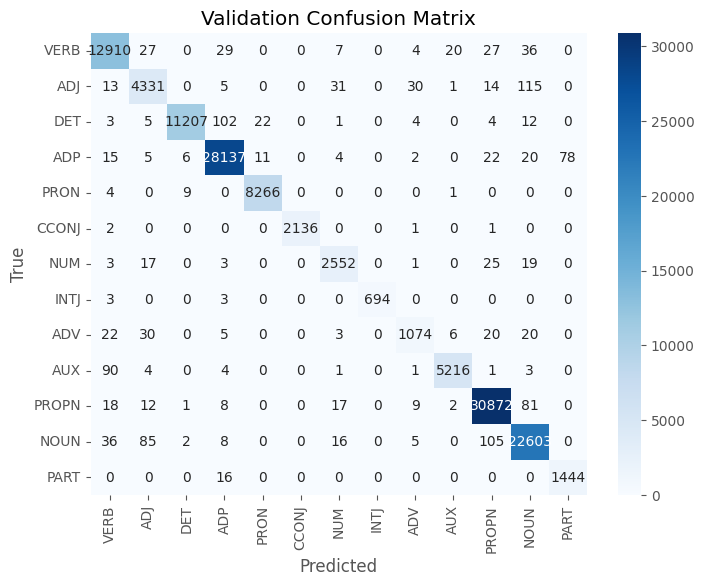

In [ ]:
conf_matrix = confusion_matrix(new_labels, new_preds)
class_labels = list(tag_map.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix')
plt.show()

In [ ]:
#--------------TEST-------------
true_test_labels = []
predicted_test_labels = []

model.eval()
with torch.no_grad():
  for i, (sent, label) in enumerate(test_loader):
      # if i == 0:
        # print("sent: ", sent)
      sent = sent.to(device)
      label = label.to(device)

      outputs = model(sent)
      to_loss_outputs = outputs.permute(0, 2, 1)
      loss = loss_function(to_loss_outputs, label)


      # optimizer.zero_grad()
      # loss.backward()
      # optimizer.step()

      _, predicted = torch.max(outputs.data, 2)
      total_samples += label.size(0)
      overall_accuracy = calculate_accuracy(predicted, label)

      true_test_labels.extend(label.cpu().numpy())
      predicted_test_labels.extend(predicted.cpu().numpy())

<ipython-input-30-d96154c9d0d4>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(predictions)
<ipython-input-30-d96154c9d0d4>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [ ]:
pad_tok_idx = 77
preds = predicted_test_labels
labs = true_test_labels

new_labels = []
new_preds = []

for pred, lab in zip(preds, labs):
  idx = np.where(lab == pad_tok_idx)[0]
  # print(idx, type(idx), len(idx))

  if len(idx) == 0:
    idx = len(pred)
  else:
    idx = idx[0]

  new_preds.append(pred[:idx])
  new_labels.append(lab[:idx])

In [ ]:
new_preds = [item for sublist in new_preds for item in sublist]
new_labels = [item for sublist in new_labels for item in sublist]

In [ ]:
print(classification_report(new_labels, new_preds))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       629
           1       0.73      0.93      0.82       220
           2       0.99      0.98      0.98       512
           3       0.98      0.99      0.99      1434
           4       0.99      0.99      0.99       392
           5       1.00      0.98      0.99       109
           6       0.90      0.76      0.83       127
           7       0.94      0.94      0.94        36
           8       0.83      0.53      0.65        76
           9       0.96      0.98      0.97       256
          10       0.97      0.98      0.98      1567
          11       0.96      0.95      0.96      1166
          12       0.98      0.86      0.91        56

    accuracy                           0.96      6580
   macro avg       0.94      0.91      0.92      6580
weighted avg       0.96      0.96      0.96      6580



In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [ ]:
cf = confusion_matrix(new_labels, new_preds)

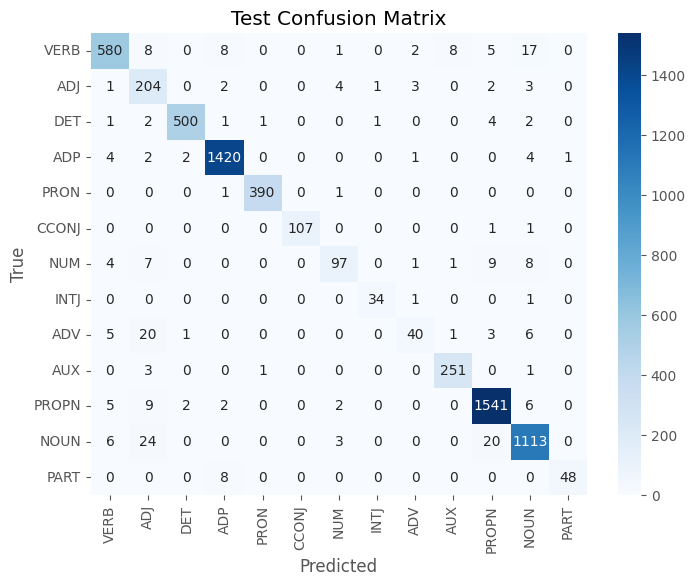

In [ ]:
class_labels = list(tag_map.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cf, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

In [ ]:
import os
os.chdir("/content/drive/MyDrive/INLP/Assignment - 2")
os.getcwd()

'/content/drive/MyDrive/INLP/Assignment - 2'

In [ ]:
torch.save(model, "lstm_model2_98acc_20epoch.pt")